# Deep Neural Network for regression to predict days_to_sell

## Environment setup and initialisation

In [116]:
import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import torch

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cuda

NVIDIA GeForce RTX 3080 Ti
Memory Usage:
Allocated: 0.7 GB
Cached:    7.3 GB


# Loading In Data

In [117]:
import pandas as pd
pd.set_option('display.max_columns', None)

# Read ds into dataframe

data_path = f"../data/rate_of_sale_may_2023.snappy.parquet"

data_dict_path = f"../data/rate_of_sale_data_dict.csv"

data = pd.read_parquet(data_path)

data_dict_df = pd.read_csv(data_dict_path)

data.head(3)



,stock_item_id,last_date_seen,first_date_seen,days_to_sell,first_retailer_asking_price,last_retailer_asking_price,can_home_deliver,reviews_per_100_advertised_stock_last_12_months,segment,seats,doors,co2_emission_gpkm,top_speed_mph,zero_to_sixty_mph_seconds,engine_power_bhp,fuel_economy_wltp_combined_mpg,battery_range_miles,battery_usable_capacity_kwh,length_mm,boot_space_seats_up_litres,insurance_group,plate,make,model,generation,derivative,derivative_id,body_type,fuel_type,transmission_type,drivetrain,colour,odometer_reading_miles,first_registration_date,attention_grabber,manufacturer_approved,price_indicator_rating,adjusted_retail_amount_gbp,predicted_mileage,number_of_images,advert_quality,postcode_area
0,52ae009b671ab58b3d4ff109a9fbdcf8d847de0fa190e1...,2023-05-05,2021-03-25,771,6995,6495.0,False,3.9,Independent,5.0,3.0,194.0,137.0,7.2,172.0,22.1,NaN,None,3803.0,NaN,31,04,Renault,Clio,Hatchback (2001 - 2005),2.0 16v Renaultsport 3dr,f910dd7ace96336e8f0d18a2d52b3a60,Hatchback,Petrol,Manual,Front Wheel Drive,None,65000,2004-05-07,*IMMACULATE**FULL HISTORY*,False,NOANALYSIS,NaN,NaN,50,NaN,AL
1,32b1bac6934b1f64ff43cffa9df5aa296ead8143c36f9f...,2023-05-09,2021-05-25,714,13725,14995.0,False,NaN,Franchise,5.0,5.0,108.0,113.0,None,99.0,50.4,NaN,None,4065.0,311.0,10,69,Ford,Fiesta,Hatchback (2017 - 2021),1.0T EcoBoost ST-Line Euro 6 (s/s) 5dr,4b854496509949d288c1bf6c9694e3f6,Hatchback,Petrol,Manual,Front Wheel Drive,Silver,16018,2019-11-30,Sports Styling | Great Economy,True,GOOD,14848.0,26078.0,15,57.0,HP
2,21703d22d87eaa95c4dc81a60ba2c8cbe3b90ab659292c...,2023-05-12,2021-11-26,532,15499,13999.0,False,0.2,Independent,5.0,5.0,144.0,112.0,12.4,110.0,44.8,NaN,None,4314.0,448.0,10,18,MG,MG ZS,SUV (2017 - 2021),1.0 T-GDI Exclusive Auto Euro 6 5dr,dc4723bdcb6d4b74b7bd4a522b854882,SUV,Petrol,Automatic,Front Wheel Drive,Blue,31093,2018-03-08,"Sat Nav,Leather,Auto,Euro 6",False,GREAT,14571.0,34732.0,22,61.0,SR


## Data Exploration

In [25]:
column_range = data['days_to_sell'].max() - data['days_to_sell'].min()

print(f"Range of days_to_sell: {column_range}")

Range of days_to_sell: 1829


### Checking distribution of target data

In [26]:
import matplotlib.pyplot as plt

days_to_sell = data['days_to_sell']

def plot_filtered_histogram(data, max_value=None, filter_data=True):
    # Optionally filter out data points exceeding max_value
    if filter_data and max_value is not None:
        filtered_data = [x for x in data if x <= max_value]
    else:
        filtered_data = data
    
    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_data, bins=30, color='skyblue', edgecolor='black')
    if max_value is not None:
        plt.title('Distribution of Days to Sell (Max Value: {})'.format(max_value))
    else:
        plt.title('Distribution of Days to Sell')
    plt.xlabel('Days to Sell')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

### Unfiltered days_to_sell distribution

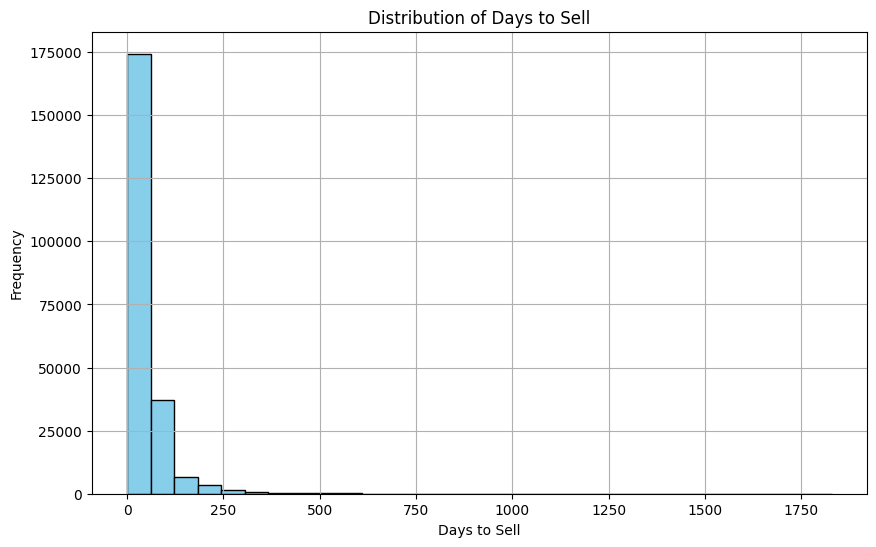

In [27]:
plot_filtered_histogram(data['days_to_sell'], filter_data=False)

Data has small amounts of data for over 365 days, best to check spread over a year

### Filtered Days_to_sell distribution (Max=365 days)

In [28]:
def points_over_n(days):
    return sum(1 for value in days_to_sell if value > days)

print("Number of entries over 100:", points_over_n(100))
print("Number of entries over 200:", points_over_n(200))
print("Number of entries over 365:", points_over_n(365))
print(f"Number of entries over 2 years:", points_over_n(365*2))

Number of entries over 100: 19472
Number of entries over 200: 5099
Number of entries over 365: 1049
Number of entries over 2 years: 66


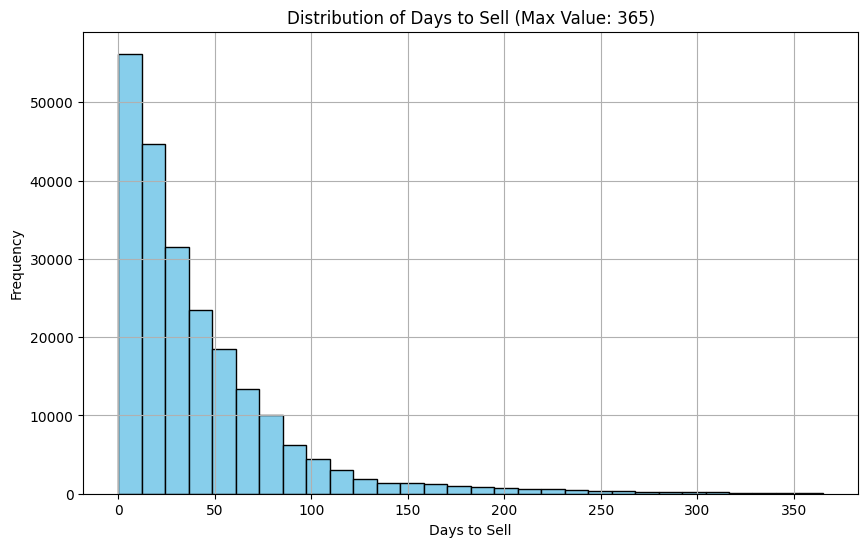

In [29]:
plot_filtered_histogram(data['days_to_sell'], max_value=365)

## Data Cleaning

In [232]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin

target = 'days_to_sell'

# Dropping rows with missing target values
data_cleaned = data.dropna(subset=[target])

unique_fuel_types = data['fuel_type'].unique()
print(unique_fuel_types)

# Assuming 'data' is your DataFrame
num_electric_cars = (data['fuel_type'] == '').sum()
print("Number of rows with 'electric' as fuel_type:", num_electric_cars)

['Petrol' 'Diesel' 'Electric' 'Petrol Plug-in Hybrid' 'Petrol Hybrid'
 'Diesel Hybrid' 'Diesel Plug-in Hybrid' 'Bi Fuel']
Number of rows with 'electric' as fuel_type: 41


## Feature Extraction

In [216]:
features = ['reg_year',
            'make',
            # 'model',
            #  'body_type',
#             'fuel_type',
#             'transmission_type',
#             'drivetrain',
            'colour',
            # 'price_indicator_rating',
            # 'postcode_area',
            'first_retailer_asking_price',
            'reviews_per_100_advertised_stock_last_12_months',
            'seats',
#             'doors',
#             'co2_emission_gpkm',
#             'top_speed_mph',
#             'zero_to_sixty_mph_seconds',
#             'engine_power_bhp',
#             'fuel_economy_wltp_combined_mpg',
#             'battery_range_miles',
#             'battery_usable_capacity_kwh',
#             'length_mm',
#             'boot_space_seats_up_litres',
            'insurance_group',
            'odometer_reading_miles',
#             'adjusted_retail_amount_gbp',
#             'predicted_mileage',
            'number_of_images',
            'advert_quality',
            'can_home_deliver',
#             'manufacturer_approved',
            'segment'
            ]

## Feature Categorization

In [217]:
categorical_features = [
                        'make',
                        # 'model',
                        # 'body_type',
                        # 'fuel_type',
                        # 'transmission_type',
                        # 'drivetrain',
                        'colour',
                        # 'price_indicator_rating',
                        # 'postcode_area',
                        'segment'
                        ]

numerical_features = ['reg_year',
                      'first_retailer_asking_price',
                      'reviews_per_100_advertised_stock_last_12_months',
                      'seats',
                    #   'doors',
                    #   'co2_emission_gpkm',
                    #   'top_speed_mph',
                    #   'zero_to_sixty_mph_seconds',
                    #   'engine_power_bhp',
                    #   'fuel_economy_wltp_combined_mpg',
                    #   'battery_range_miles',
                    #   'battery_usable_capacity_kwh',
                    #   'length_mm',
                    #   'boot_space_seats_up_litres',
                      'insurance_group',
                      'odometer_reading_miles',
                    #   'adjusted_retail_amount_gbp',
                    #   'predicted_mileage',
                      'number_of_images',
                      'advert_quality',
                      ]

binary_features = [
    'can_home_deliver',
                    # 'manufacturer_approved'
                    ]

## Data Preperation Pipeline

In [218]:
# Function to calculate registration year from plate
def plate_to_year(identifier):
    if not identifier:
        return identifier
    
    # Direct mapping of first letter to registration year
    letter_year_map = {
      'A': 1983, 'B': 1984, 'C': 1985, 'D': 1986, 'E': 1987, 
      'F': 1988, 'G': 1989, 'H': 1990, 'J': 1991, 'K': 1992, 
      'L': 1993, 'M': 1994, 'N': 1995, 'P': 1996, 'R': 1997, 
      'S': 1998, 'T': 1999, 'V': 1999, 'W': 2000, 'X': 2000,
      'Y': 2001
    }
    
    # Check if the identifier is a letter or a number
    if isinstance(identifier, str) and identifier.upper() in letter_year_map:
      # Handle letter-based registration year
      return letter_year_map[identifier.upper()]
    elif isinstance(identifier, int) or (isinstance(identifier, str) and identifier.isdigit()):
      # Convert string digits to integer if necessary
      plate_year = int(identifier)
      # Handle number-based registration year
      if plate_year < 50:
          # For plates issued from March to August
          return 2000 + plate_year
      else:
          # For plates issued from September to February of the following year
          return 1950 + plate_year
    else:
      print(identifier)
      raise ValueError("Invalid identifier in 'plate_to_year' function.")
    

    
# # Function to calculate percentage through the year
# def days_from_epoch(date_str):

#     date_obj = datetime.strptime(str(date_str), "%Y-%m-%d")

#     return (date_obj - datetime(1970,1,1)).days

#     # day_of_year = date_obj.timetuple().tm_yday
#     # # Check if it's a leap year
#     # is_leap_year = date_obj.year % 4 == 0 and (date_obj.year % 100 != 0 or date_obj.year % 400 == 0)
    
#     # total_days_in_year = 366 if is_leap_year else 365
#     # percentage = (day_of_year / total_days_in_year)


def extract_features(data_frame):
    """Takes a raw row of X_data and extracts the needed features from them
        args:
            data_frame: a pandas dataframe containing the car data
    """
    # Convert first seen date to percentage through year to reflect
    # data_frame['listing_from_epoch'] = data_frame['first_date_seen'].apply(days_from_epoch)
    data_frame['reg_year'] = data_frame['plate'].apply(plate_to_year)

    # print(data_frame[features].shape)
    # data_frame[numerical_features].hist(color='skyblue', alpha=0.7, bins=20, figsize=(15, 10), layout=(5, 6))

    # # Set titles font size for each subplot
    # for ax in plt.gcf().get_axes():
    #     ax.title.set_fontsize(10)

    # # Set overall title
    # plt.suptitle('Histograms', fontsize=14)

    # # Adjust spacing between subplots
    # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

    # plt.show()

    # check it was working
    # print(data_frame['reg_year'].head(10))
    # Filter the DataFrame for rows where 'days_to_sell' is larger than 364

    # unique_values = sorted(data_frame['reg_year'].unique())

    # print("Unique values of 'reg_year':")
    # print(unique_values)
    # Sort the filtered DataFrame by 'days_to_sell'
    # Take the first 10 samples
    # Plotting
    # plt.figure(figsize=(10, 6))
    # plt.scatter(data_frame['days_to_sell'], data_frame['percentage_through_year'], marker='o',)
    # plt.title('Days to Sell vs. Percentage Through Year')
    # plt.xlabel('Days to Sell')
    # plt.ylabel('Percentage Through Year')
    # plt.grid(True)
    # plt.show()
    
    return data_frame[features]

# Numeric Transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Categoric Transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])


column_transformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('binary', 'passthrough', binary_features)
    ])

def preprocess_data(x_df):
    return column_transformer.fit_transform(extract_features(x_df))

# preprocess features
X = preprocess_data(data_cleaned)

# target values
Y = data_cleaned[target].values


## Split train/test data

In [219]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Train dataset shape: {x_train.shape}")
print(f"Test dataset shape: {x_test.shape}")

Train dataset shape: (178804, 102)
Test dataset shape: (44702, 102)



## Random Forests Baseline

In [220]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

param_space = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [2, 3, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, min_samples_leaf=2, min_samples_split=2, n_jobs=8 ,max_depth=100, verbose=1)

rf_model.fit(x_train, y_train)

# rf_model = RandomForestRegressor()

# rf_random = RandomizedSearchCV(rf_model, param_space, n_iter=100, scoring='neg_mean_squared_error', n_jobs=8, cv=5,verbose=2)
# model_random = rf_random.fit(x_train,y_train)

# Results of random cross validation
# print('Best random search hyperparameters are: '+str(model_random.best_params_))
# print('Best random search score is: '+str(model_random.best_score_))

# We'll evaluate the model's performance next
# results = rf_random.cv_results_

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    9.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   26.1s finished


RandomForestRegressor(max_depth=100, min_samples_leaf=2, n_jobs=8,
                      random_state=42, verbose=1)

In [222]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Making predictions on the test set
y_pred = rf_model.predict(x_test)

# Calculating the Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Calculating the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate the Root Mean Squared Error
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error: {rmse}")
# Calculating the R-squared value
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

Mean Absolute Error: 28.5937290542189
Mean Squared Error: 1810.4967267843872
Root Mean Squared Error: 42.54993215957444
R-squared: 0.14634715731726555


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


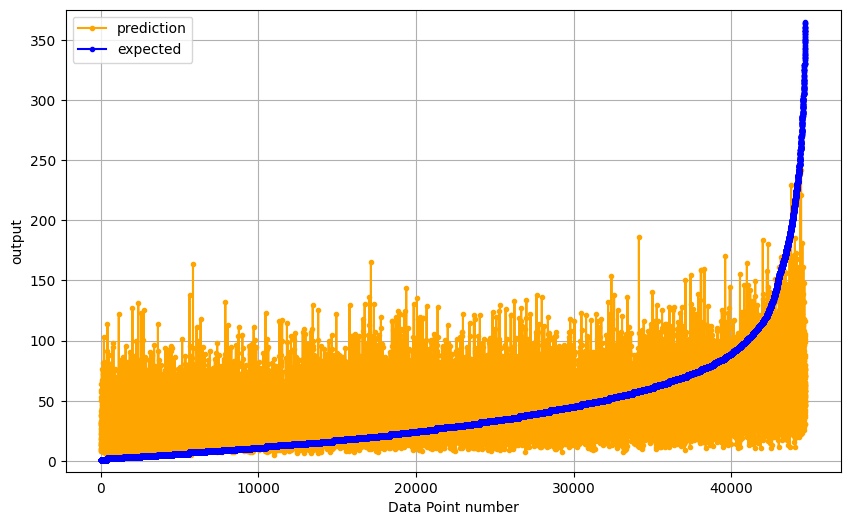

In [223]:
def chart_regression_filtered(pred, y, sort=True, max_days=365, bins=100):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    
    # Remove outliers above max_days
    t = t[t['y'] <= max_days]

    if sort:
        t.sort_values(by=['y'], inplace=True)
    
    # Plotting with a finer resolution
    plt.figure(figsize=(10, 6))
    plt.plot(t['pred'].tolist(), label='prediction', marker='o', markersize=3, linestyle='-', color='orange')
    plt.ylabel('output')
    plt.xlabel('Data Point number')
    
    # Setting y-axis limits
    plt.ylim(min(t['pred'].min(), t['y'].min()) - 10, max(t['pred'].max(), t['y'].max()) + 10)
    
    plt.plot(t['y'].tolist(), label='expected', marker='o', markersize=3, linestyle='-', color='blue')
    
    plt.legend()
    plt.grid(True)
    plt.show()

chart_regression_filtered(y_pred, y_test)

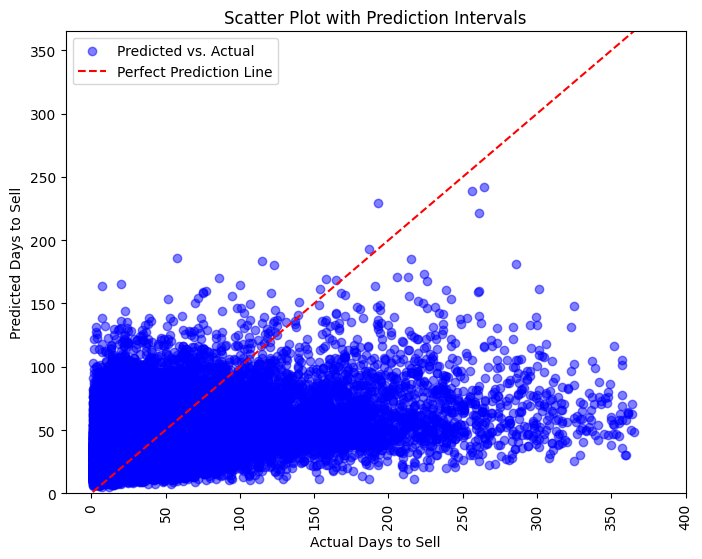

In [224]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# def scatter_with_prediction_intervals(test, pred):
#     plt.figure(figsize=(8, 6))
#     plt.scatter(test, pred, color='blue', alpha=0.5, label='Predicted vs. Actual')
#     plt.plot([min(test), max(test)], [min(test), max(test)], color='red', linestyle='--', label='Perfect Prediction Line')
#     plt.title('Scatter Plot with Prediction Intervals')
#     plt.xlabel('Actual Days to Sell')
#     plt.ylabel('Predicted Days to Sell')
#     plt.legend()
    
#     # Set custom ticks on x-axis with intervals of 20 days
#     x_ticks = np.arange(0, max(y_test) + 50, 50)
#     plt.xticks(x_ticks,rotation='vertical')
    
#     plt.show()


def scatter_with_prediction_intervals(test, pred):
    # Filter data points with predicted values over 365
    filtered_test = []
    filtered_pred = []
    for i in range(len(test)):
        if pred[i] <= 365:
            filtered_test.append(test[i])
            filtered_pred.append(pred[i])
    
    plt.figure(figsize=(8, 6))
    plt.scatter(filtered_test, filtered_pred, color='blue', alpha=0.5, label='Predicted vs. Actual')
    plt.plot([min(filtered_test), max(filtered_test)], [min(filtered_test), max(filtered_test)], color='red', linestyle='--', label='Perfect Prediction Line')
    plt.title('Scatter Plot with Prediction Intervals')
    plt.xlabel('Actual Days to Sell')
    plt.ylabel('Predicted Days to Sell')
    plt.legend()
    
    # Set custom ticks on x-axis with intervals of 20 days
    x_ticks = np.arange(0, max(filtered_test) + 50, 50)
    plt.xticks(x_ticks, rotation='vertical')
    
    # Set y-axis limit
    plt.ylim(0, 365)  # Adjust the upper limit as needed
    
    plt.show()

scatter_with_prediction_intervals(y_test, y_pred)

In [142]:
# Class for early stopping - code taken from Jeff Heatonhttps://www.youtube.com/watch?v=lS0vvIWiahU&pp=ygUZamVmZiBoZWF0b24gZWFybHkgc3RvcHBlcg%3D%3D

import copy

class EarlyStopper():
    def __init__(self, patience=5, min_delta=1e-2, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):

        #deal with inital call
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())

        # cases where loss has improved
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Found Improvement - Counter reset to {self.counter}!"

        else: 
            # increment counter
            self.counter += 1
            self.status = f"No Improvement in last {self.counter} epochs!"

            #if counter exceeded - no improvement
            if self.counter >= self.patience: 
                self.status = f"Early Stopping triggered after {self.counter} epochs!"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

## Deep Learning Neural Network for Regression

In [183]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from sklearn import preprocessing
from torch.utils.data import DataLoader, TensorDataset
import tqdm
import time

class Net(nn.Module):
    def __init__(self, in_count, out_count):
        super(Net, self).__init__()
        print(f"incount: {in_count}")
        hidden_neurons = [66, 38, 16]
        self.fc1 = nn.Linear(in_count, hidden_neurons[0])
        self.fc2 = nn.Linear(hidden_neurons[0], hidden_neurons[1])
        self.fc3 = nn.Linear(hidden_neurons[1], hidden_neurons[2])
        # self.fc4 = nn.Linear(hidden_neurons[2], hidden_neurons[3])
        # self.fc5 = nn.Linear(hidden_neurons[3], hidden_neurons[4])
        self.fc6 = nn.Linear(hidden_neurons[2], out_count)

    def forward(self, x):
        # Apply activation function 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # x = F.relu(self.fc4(x))
        # x = F.relu(self.fc5(x))
        # Output layer
        x = self.fc6(x)
        return x
    

# Np -> Torch Tensor
    
x_train_tensor = torch.Tensor(x_train).float()
y_train_tensor = torch.Tensor(y_train).float()

x_test_tensor = torch.Tensor(x_test).float().to(device)
y_test_tensor = torch.Tensor(y_test).float().to(device)

# Create datasets

BATCH_SIZE = 64

dataset_train = TensorDataset(x_train_tensor, y_train_tensor)
dataloader_train = DataLoader(dataset_train,batch_size=BATCH_SIZE, shuffle=True) 

dataset_test = TensorDataset(x_test_tensor, y_test_tensor)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True) 

# define model
nn_model = Net(X.shape[1],1).to(device)

# define loss function

loss_fn = nn.MSELoss()

# define optimizer

optimizer = torch.optim.Adam(nn_model.parameters())

# Define early stop

es = EarlyStopper()

# Init Run

epoch = 0
done = False

while epoch < 1000 and not done:
    epoch += 1
    steps = list(enumerate(dataloader_train))
    pbar = tqdm.tqdm(steps)
    nn_model.train()

    for i, (x_batch, y_batch) in pbar:
        y_batch_pred = nn_model(x_batch.to(device)).flatten()
        loss = loss_fn(y_batch_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), (i + 1) * len(x_batch)

        if i == len(steps) - 1:
            nn_model.eval()
            pred = nn_model(x_test_tensor).flatten()
            vloss = loss_fn(pred, y_test_tensor)

            if es(nn_model, vloss): done = True
            pbar.set_description(f"Epoch: {epoch}, tloss: {loss}, vloss: {vloss:>7f}, EStop:[{es.status}]")
        else:
            pbar.set_description(f"Epoch: {epoch}, tloss {loss:}")

incount: 103


Epoch: 1, tloss: 3767.79443359375, vloss: 3525.844238, EStop:[]: 100%|██████████| 2807/2807 [00:07<00:00, 351.88it/s]
Epoch: 2, tloss: 1101.705810546875, vloss: 3555.257080, EStop:[No Improvement in last 1 epochs!]: 100%|██████████| 2807/2807 [00:08<00:00, 339.54it/s]
Epoch: 3, tloss: 2816.3583984375, vloss: 3433.306152, EStop:[Found Improvement - Counter reset to 0!]: 100%|██████████| 2807/2807 [00:08<00:00, 343.45it/s]
Epoch: 4, tloss: 2017.4229736328125, vloss: 3580.820801, EStop:[No Improvement in last 1 epochs!]: 100%|██████████| 2807/2807 [00:07<00:00, 351.33it/s]
Epoch: 5, tloss: 2179.798095703125, vloss: 3605.039795, EStop:[No Improvement in last 2 epochs!]: 100%|██████████| 2807/2807 [00:08<00:00, 350.72it/s]
Epoch: 6, tloss: 2040.46484375, vloss: 3412.761475, EStop:[Found Improvement - Counter reset to 0!]: 100%|██████████| 2807/2807 [00:08<00:00, 344.66it/s]
Epoch: 7, tloss: 2416.127685546875, vloss: 3634.400146, EStop:[No Improvement in last 1 epochs!]: 100%|██████████| 280

In [184]:
from sklearn import metrics
# Making predictions
pred = nn_model(x_test_tensor)

# Calculating Mean Squared Error (MSE)
mse = metrics.mean_squared_error(pred.cpu().detach().numpy(), y_test_tensor.cpu().detach().numpy())
print("Final score (MSE): {}".format(mse))

# Calculating Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Final score (RMSE): {}".format(rmse))

Final score (MSE): 3412.760986328125
Final score (RMSE): 58.41884231567383


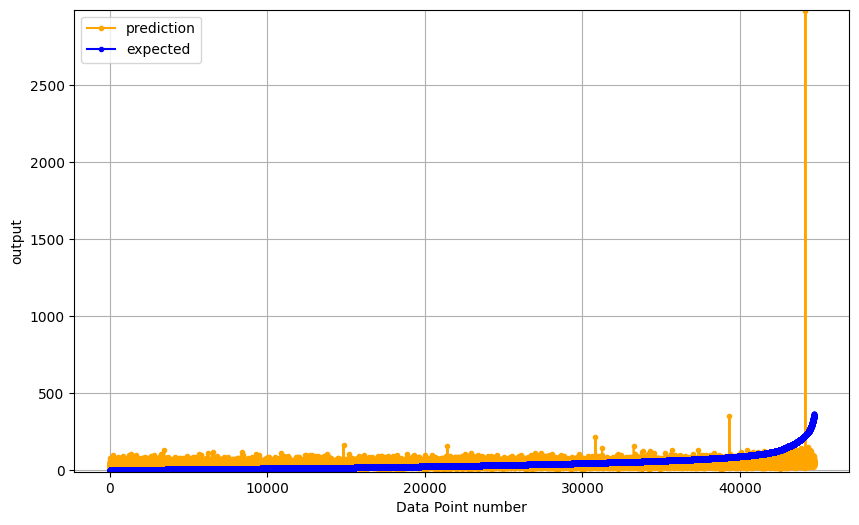

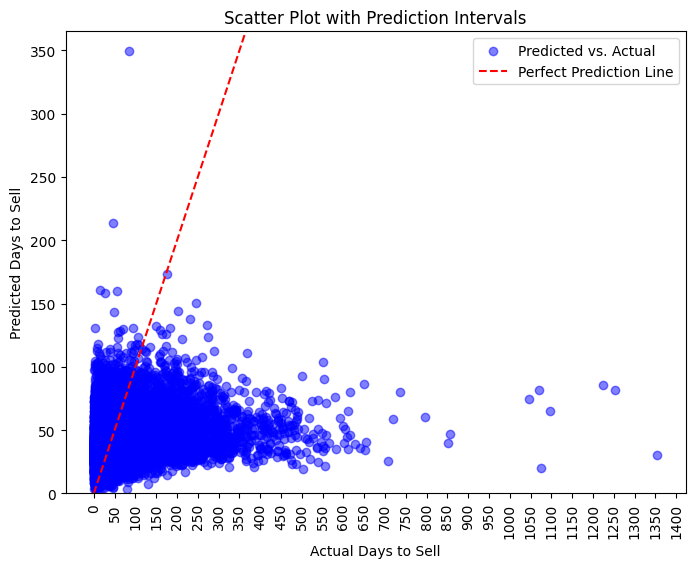

In [177]:
pred_x = pred.cpu().detach().numpy().flatten()
pred_y = y_test_tensor.cpu().detach().numpy()
chart_regression_filtered(pred_x, pred_y)
scatter_with_prediction_intervals(pred_y, pred_x)